In [1]:
import numpy as np
from tqdm import tqdm
import xarray as xr
import matplotlib.pyplot as plt
import warnings
from itertools import product
# from lmphoton.simulation import current_simulation as sim
from scipy.optimize import minimize
from scipy.constants import constants
import pandas as pd
import seaborn as sns
from sppd_dfb_laser import SPPDDFB, SPPDCLMPIC
from enablence_mux import EBMUX
from sppd_clm_optics import SPPDCLMOPTICS
from sppd_clm_calibration import SPPDCLMCAL
from sppd_clm_control import SPPDCLMCONTROL


In [2]:
target_grid_array = np.array([
  1301.47, 1302.60, 1303.73, 1304.87,
  1306.01, 1307.14, 1308.28, 1309.43,
  1310.57, 1311.72, 1312.87, 1314.02,
  1315.17, 1316.33, 1317.48, 1318.64])*1e-9 

wavelength_A = np.array([
  1301.47, 1303.73, 1306.01, 1308.28,
  1310.57, 1312.87, 1315.17, 1317.48,
  ])*1e-9

wavelength_B = np.array([
  1302.60, 1304.87, 1307.14, 1309.43,
  1311.72, 1314.02, 1316.33, 1318.64
  ])*1e-9

_sppd_clm_optics_A = SPPDCLMOPTICS(
  target_grid_array = target_grid_array,
  wavelength_fabrication= wavelength_A,
  name = "SPPDCLMOPTICS_LAMBDA_A"
  )

print("Wavelength bank A")

current_array = np.ones(8) * 0.125
_sppd_clm_optics_A.update(tc = 273+30.0, i_array=current_array)
for idd_laser in range(len(current_array)):
  print(f"{idd_laser}: {_sppd_clm_optics_A._lambda_array[idd_laser]*1e9:0.2f} nm")
for idd_target_wavelength in range(len(target_grid_array)):
  print(f"{idd_target_wavelength}: {_sppd_clm_optics_A._mpd_current_array[idd_target_wavelength]*1e6:0.2f} uA")
  


Wavelength bank A
0: 1299.89 nm
1: 1302.15 nm
2: 1304.43 nm
3: 1306.70 nm
4: 1308.99 nm
5: 1311.29 nm
6: 1313.59 nm
7: 1315.90 nm
0: 31.36 uA
1: 110.43 uA
2: 30.95 uA
3: 119.25 uA
4: 30.95 uA
5: 120.79 uA
6: 30.95 uA
7: 121.42 uA
8: 30.95 uA
9: 130.11 uA
10: 30.95 uA
11: 128.90 uA
12: 30.95 uA
13: 131.35 uA
14: 30.95 uA
15: 30.95 uA


Nominal temperature for laser 0: 45.71 C
Nominal temperature for laser 1: 45.71 C
Nominal temperature for laser 2: 45.71 C
Nominal temperature for laser 3: 45.71 C
Nominal temperature for laser 4: 45.71 C
Nominal temperature for laser 5: 45.71 C
Nominal temperature for laser 6: 45.71 C
Nominal temperature for laser 7: 45.71 C
TEC set point temperature: 45.71 C
Peak MPD current for laser 0: 0.89 mA
Peak MPD current for laser 1: 0.89 mA
Peak MPD current for laser 2: 0.89 mA
Peak MPD current for laser 3: 0.89 mA
Peak MPD current for laser 4: 0.89 mA
Peak MPD current for laser 5: 0.89 mA
Peak MPD current for laser 6: 0.89 mA
Peak MPD current for laser 7: 0.89 mA


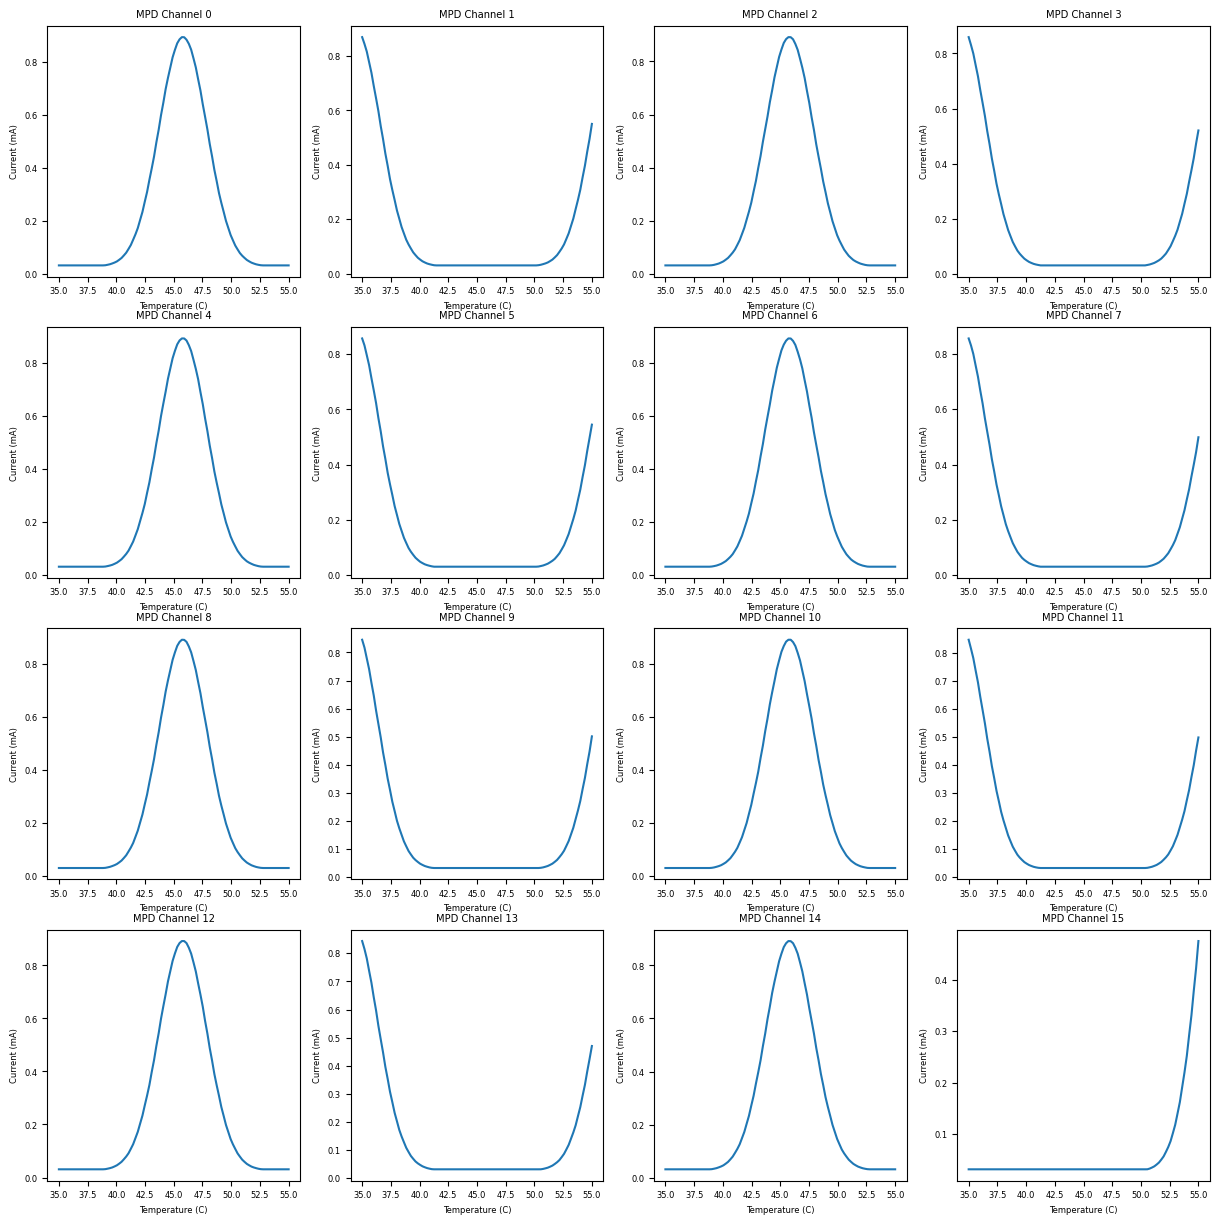

In [3]:
_sppd_cal = SPPDCLMCAL(_sppd_clm_optics_A)
cal_temperature_array = np.linspace(35, 55, 100) + 273
cal_current = 0.125
tec_set_point_temperature, nom_temp_array, mux_current_array, peak_current_array = _sppd_cal.calibrate(cal_temperature_array, cal_current)
# Print nominal temperature array for each laser
for idd_laser in range(len(current_array)):
  print(f"Nominal temperature for laser {idd_laser}: {nom_temp_array[idd_laser]-273:0.2f} C")
# Print tec set point temperature
print(f"TEC set point temperature: {tec_set_point_temperature-273:0.2f} C")
# Print peak current array for each laser
for idd_laser in range(len(current_array)):
  print(f"Peak MPD current for laser {idd_laser}: {peak_current_array[idd_laser]*1e3:0.2f} mA")
# Plot calibration per MUX channel (columns) and temperature (rows)
n_mpd_channels = len(target_grid_array)
# Set font size small
plt.rc('font', size=6)
fig, ax = plt.subplots(int(np.sqrt(n_mpd_channels)), int(np.sqrt(n_mpd_channels)), figsize=(15, 15))
for idd_mpd_channel in range(n_mpd_channels):
  _ax = ax[int(idd_mpd_channel/np.sqrt(n_mpd_channels)), int(idd_mpd_channel%np.sqrt(n_mpd_channels))]
  _ax.plot(cal_temperature_array-273, mux_current_array[:, idd_mpd_channel]*1e3)
  _ax.set_xlabel("Temperature (C)")
  _ax.set_ylabel("Current (mA)")
  _ax.set_title(f"MPD Channel {idd_mpd_channel}")


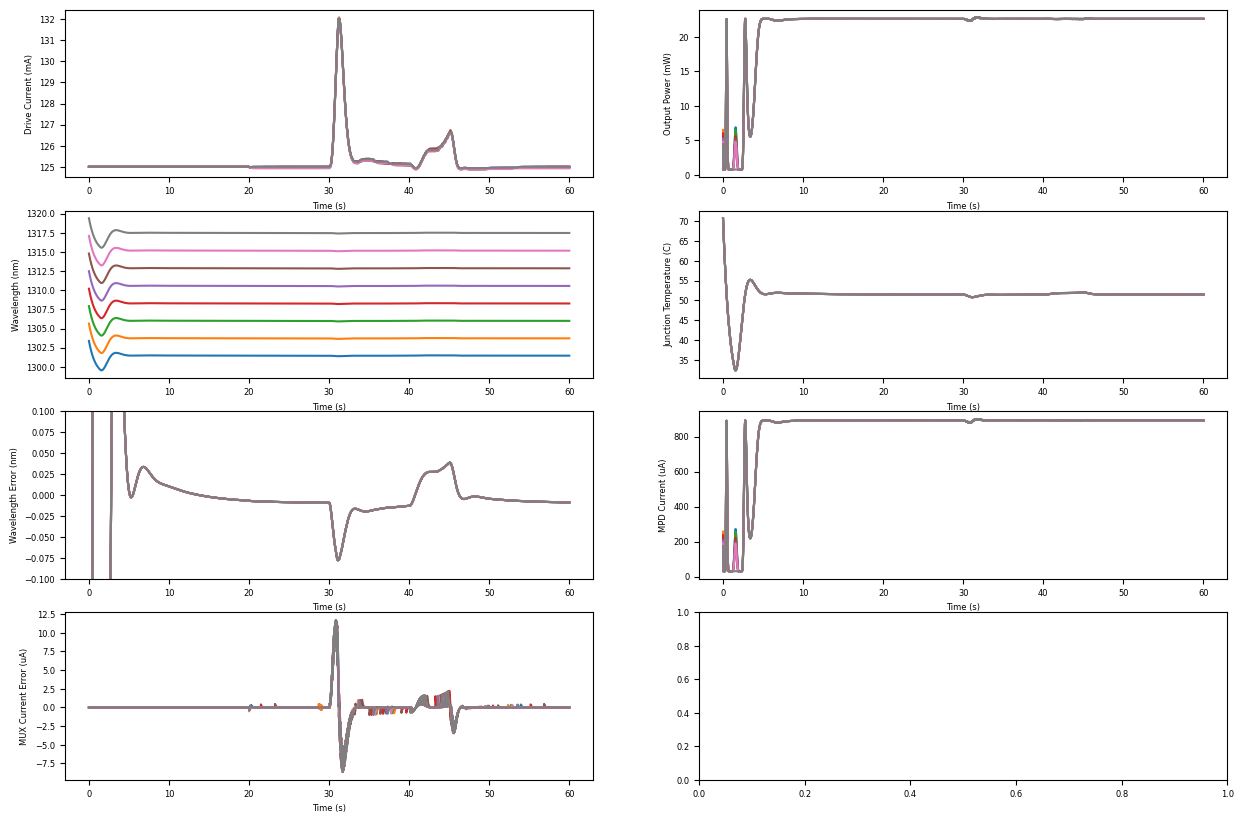

In [4]:
from laser_control.pid import pid
dt = 1e-2
_sppd_clm_control = SPPDCLMCONTROL(sppd_clm_optics=_sppd_clm_optics_A, 
                                   tec_set_point_temperature =  tec_set_point_temperature,
                                   drive_current_array= 0.125*np.ones(8),
                                   mux_current_array =  peak_current_array,
                                   pid_tec = pid(kp=0.5, ki=10*dt, kd=10*dt, dt=dt, umax=3, umin=-3), 
                                   pid_idrive = [pid(kp=10, ki=100000*dt, kd=0.001, dt=dt) for i in range(8)])
t, laser_drive_current_array, laser_output_power_array, laser_wavelength_array, laser_junction_temperature_array, laser_mpd_current_array, q, i_tec, v_tec, t_case = _sppd_clm_control.run()

# Plot results

wavelength_error = (laser_wavelength_array - target_grid_array[::2].reshape(8,1))
fig, ax = plt.subplots(4, 2, figsize=(15, 10))
ax[0, 0].plot(t, laser_drive_current_array.T*1e3)
ax[0, 0].set_xlabel("Time (s)")
ax[0, 0].set_ylabel("Drive Current (mA)")
ax[0, 1].plot(t, laser_output_power_array.T*1e3)
ax[0, 1].set_xlabel("Time (s)")
ax[0, 1].set_ylabel("Output Power (mW)")
ax[1, 0].plot(t, laser_wavelength_array.T*1e9)
ax[1, 0].set_xlabel("Time (s)")
ax[1, 0].set_ylabel("Wavelength (nm)")
ax[1, 1].plot(t, laser_junction_temperature_array.T-273)
ax[1, 1].set_xlabel("Time (s)")
ax[1, 1].set_ylabel("Junction Temperature (C)")
ax[2, 0].plot(t, wavelength_error.T*1e9)
ax[2, 0].set_xlabel("Time (s)")
ax[2, 0].set_ylabel("Wavelength Error (nm)")
ax[2, 0].set_ylim(-0.1, 0.1)
ax[2, 1].plot(t, laser_mpd_current_array.T*1e6)
ax[2, 1].set_xlabel("Time (s)")
ax[2, 1].set_ylabel("MPD Current (uA)")
ax[3, 0].plot(t, _sppd_clm_control._laser_mux_current_error.T*1e6)
ax[3, 0].set_xlabel("Time (s)")
ax[3, 0].set_ylabel("MUX Current Error (uA)")

plt.show()

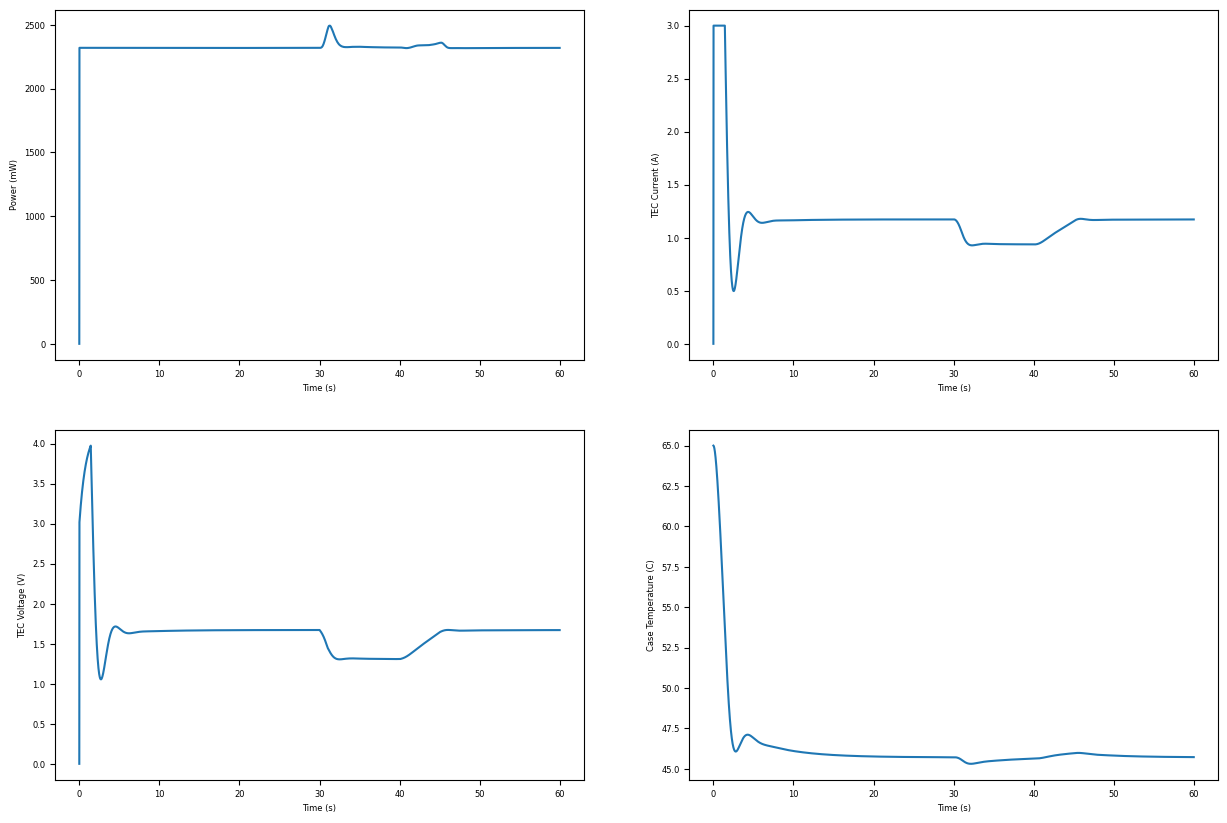

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].plot(t, q*1e3)
ax[0, 0].set_xlabel("Time (s)")
ax[0, 0].set_ylabel("Power (mW)")
ax[0, 1].plot(t, i_tec)
ax[0, 1].set_xlabel("Time (s)")
ax[0, 1].set_ylabel("TEC Current (A)")
ax[1, 0].plot(t, v_tec)
ax[1, 0].set_xlabel("Time (s)")
ax[1, 0].set_ylabel("TEC Voltage (V)")
ax[1, 1].plot(t, t_case-273)
ax[1, 1].set_xlabel("Time (s)")
ax[1, 1].set_ylabel("Case Temperature (C)")
plt.show()

In [6]:
print('TEC Hot side: ', _sppd_clm_control._tec.Th - 273)
print('TEC Cold side: ', _sppd_clm_control._tec.Ta - 273)
print('Wavelength error:', np.mean(wavelength_error[:, -1])*1e9, 'nm')

TEC Hot side:  64.99000000000001
TEC Cold side:  45.71464239718449
Wavelength error: -0.008679855951394077 nm
